In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from os import listdir
import matplotlib.pyplot as plt
from scipy import stats
sns.set(style="ticks", font_scale=1.2) # font="Arial", 
plt.rc("axes.spines", top=False, right=False)

In [2]:
# Define task below. Should be one of "capitals-recall", "capitals-recognition", or "animals".
# Change this and run all cells to process the model + human data for a given task.
TASK = "vision"

# 0. Helper functions and global variables for plotting

In [3]:
# Define list of models.
MODELS = ["vit_base_patch16_224", "vit_small_patch16_224"]
VOCAB_SIZE = 16
N_LAYERS = 12

# Define list of meta variables for the tasks.
TASK_META_VAR_MAP = {
    "capitals-recall": ["entity", "correct", "intuitive", "population_ratio"],
    "capitals-recognition": ["entity", "correct", "intuitive", "population_ratio"],
    "animals": ["condition", "exemplar", "correct", "intuitive"],
    "vision": []
}
TASK_META_VARS = TASK_META_VAR_MAP[TASK]
ITEM_META_VAR_MAP = {
    "capitals-recall": ["model", "item_id"],
    "capitals-recognition": ["model", "item_id", "condition"],
    "animals": ["model", "item_id"],
    "vision": ["model", "item_id", "dataset_name"]
}
ITEM_META_VARS = ITEM_META_VAR_MAP[TASK]

# Define output IVs (from the final layer).
OUTPUT_IV_MAP = {
    "entropy": "output_entropy",
    "rank_correct": "output_rank_correct",
    "logprob_correct": "output_logprob_correct",
}
OLD_OUTPUT_IVS = ["entropy", "rank_correct", "logprob_correct"]
OUTPUT_IVS = [OUTPUT_IV_MAP[i] for i in OLD_OUTPUT_IVS]
print(f"OUTPUT measures ({len(OUTPUT_IVS)}):", OUTPUT_IVS)

METRIC_MAP = {
    "Entropy": "entropy",
    "Layerwise Reciprocal Rank": "rank_correct",
    "Log Probability": "logprob_correct",
    "Probability": "prob_correct"
}

# Define process IVs based purely on probabilities.
PROB_IVS = []
for output_iv in OUTPUT_IVS:
    # Get base name of metric (e.g., "entropy")
    iv = output_iv.replace("output_", "")
    # Add AUC and biggest change measures.
    PROB_IVS.append(f"auc_{iv}")
    PROB_IVS.append(f"layer_biggest_change_{iv}")

PROCESS_IVS = PROB_IVS
print(f"PROCESS measures ({len(PROCESS_IVS)}):", PROCESS_IVS)


def get_metric_group(iv):
    if "entropy" in iv:
        return "Uncertainty"
    elif "rank" in iv or "logprob_correct" in iv:
        return "Confidence"

METRIC_GROUP_PAL = {
    "Uncertainty": "#FF7676FF",
    "Confidence": "#F9D662FF"
}

# Helper function for rendering a figure.
FIGURE_DIR = "../../figures"
def render_figure(outpath, render=True):
    if render:
        plt.savefig(f"{FIGURE_DIR}/{outpath}", dpi=300, bbox_inches="tight")
        print(f"Saved figure to {FIGURE_DIR}/{outpath}")
    else:
        print("Not saving figure")

OUTPUT measures (3): ['output_entropy', 'output_rank_correct', 'output_logprob_correct']
PROCESS measures (6): ['auc_entropy', 'layer_biggest_change_entropy', 'auc_rank_correct', 'layer_biggest_change_rank_correct', 'auc_logprob_correct', 'layer_biggest_change_logprob_correct']


# 1. Read and process model outputs

## Read data and do basic processing

In [4]:
def read_model_data(model="vit_base_patch16_224", logprob=False):
    print(f"Reading model data for the following model: {model}")
    data_dir = f"../../src/vision/model-vs-human/raw-data/metrics/{model}"
    datasets = listdir(data_dir)
    entropy_df = pd.concat([
        pd.read_csv(f"{data_dir}/{dataset}/Entropy.csv")
        for dataset in datasets
    ])
    rank_df = pd.concat([
        pd.read_csv(f"{data_dir}/{dataset}/Layerwise Reciprocal Rank.csv")
        for dataset in datasets
    ])
    prob_df = pd.concat([
        pd.read_csv(f"{data_dir}/{dataset}/Probability.csv")
        for dataset in datasets
    ])
    prob_metric = "prob_correct"
    if logprob:
        prob_df["metric_name"] = "Log Probability"
        prob_df["value"] = np.log(prob_df["value"])
        prob_metric = "logprob_correct"
    
    dfs = [entropy_df, rank_df, prob_df]
    index = ITEM_META_VARS + ["layer"]
    for i, df in enumerate(dfs):
        metric = df["metric_name"].values[0] 
        df = df.drop(columns=["metric_name"]).rename(columns={
            "value": METRIC_MAP[metric],
            "subj": "model",
            "stimulus": "item_id"
        }).set_index(index)
        dfs[i] = df
        
    df = dfs[0].merge(dfs[1], on=index).merge(dfs[2], on=index).reset_index()
    
    # Add column for whether the layer is the final layer.
    # This is model-dependent.
    max_layer = df["layer"].max()
    df["is_final_layer"] = df["layer"] == max_layer

    return df

In [5]:
df = pd.concat([
    read_model_data(model=model, logprob=True)
    for model in MODELS
])
df.head()

Reading model data for the following model: vit_base_patch16_224
Reading model data for the following model: vit_small_patch16_224


,model,item_id,dataset_name,layer,entropy,rank_correct,logprob_correct,is_final_layer
0,vit_base_patch16_224,0001_lp_dnn_40_chair_10_n04099969_7577.png,low-pass,0,2.365237,0.250000,-2.346391,False
1,vit_base_patch16_224,0001_lp_dnn_40_chair_10_n04099969_7577.png,low-pass,1,2.550632,0.333333,-2.239163,False
2,vit_base_patch16_224,0001_lp_dnn_40_chair_10_n04099969_7577.png,low-pass,2,2.595342,0.166667,-2.617676,False
3,vit_base_patch16_224,0001_lp_dnn_40_chair_10_n04099969_7577.png,low-pass,3,2.643830,0.111111,-2.792522,False
4,vit_base_patch16_224,0001_lp_dnn_40_chair_10_n04099969_7577.png,low-pass,4,2.650365,0.090909,-3.162579,False


## Visualize layer-wise data

Saved figure to ../../figures/vision_entropy_vit_base_patch16_224.pdf


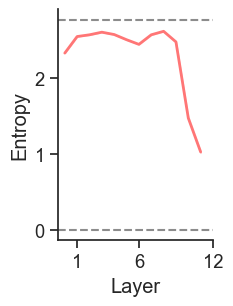

Saved figure to ../../figures/vision_rank_correct_vit_base_patch16_224.pdf


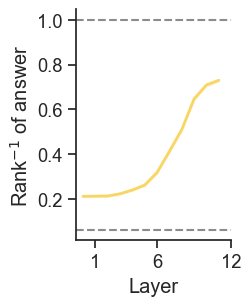

Saved figure to ../../figures/vision_logprob_correct_vit_base_patch16_224.pdf


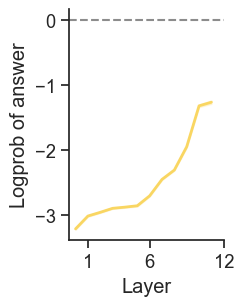

Saved figure to ../../figures/vision_entropy_vit_small_patch16_224.pdf


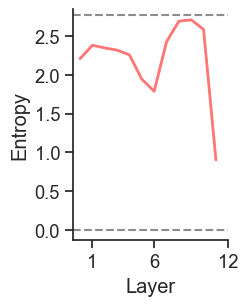

Saved figure to ../../figures/vision_rank_correct_vit_small_patch16_224.pdf


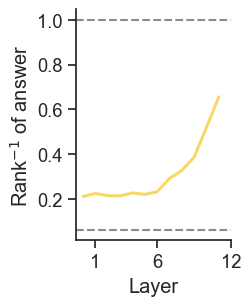

Saved figure to ../../figures/vision_logprob_correct_vit_small_patch16_224.pdf


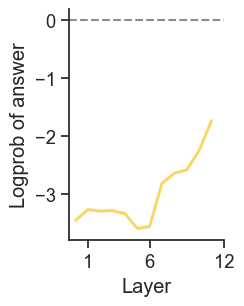

In [6]:
def get_metric_meta_data(metric):
    if metric == "rank_correct":
        ylabel = "Rank$^{-1}$ of answer"
        refs = [1/VOCAB_SIZE, 1] # minimum and maximum reciprocal rank
    elif metric == "prob_correct":
        ylabel = "Prob of answer"
        refs = [0, 1] # minimum and maximum prob
    elif metric == "logprob_correct":
        ylabel = "Logprob of answer"
        refs = [0] # maximum logprob
    elif metric == "entropy":
        ylabel = "Entropy"
        refs = [0, np.log(VOCAB_SIZE)] # minimum and maximum entropy
    else:
        raise ValueError(f"Unrecognized metric: {metric}")
    return ylabel, refs

def plot_layerwise_metric_single(df, metric, one_index=True):
    ylabel, refs = get_metric_meta_data(metric)
    ax = sns.lineplot(
        data=df,
        x="layer",
        y=metric,
        lw=2,
        color=METRIC_GROUP_PAL[get_metric_group(metric)]
    )
    ax.set_xlabel("Layer")
    ax.set_ylabel(ylabel)
    if one_index:
        xticks = [1, int(N_LAYERS/2), N_LAYERS]
        ax.set_xticks(xticks, [str(x) for x in xticks])
    for y in refs:
        ax.axhline(y=y, linestyle="--", color="k", alpha=0.5, zorder=-2)
    plt.gcf().set_size_inches(2,3)

def plot_metrics(df, task=TASK, render=False, file_suffix="", one_index=True):
    for metric in ["entropy", "rank_correct", "logprob_correct"]:
        plot_layerwise_metric_single(df, metric, one_index=one_index)
        render_figure(f"{task}_{metric}{file_suffix}.pdf", render=render)
        plt.show()

for model in df.model.unique():
    plot_metrics(df[df.model==model], task=TASK, render=True, file_suffix=f"_{model}")

## Compute all metrics

In [7]:
def get_index_of_biggest_change(vals, negative_change=False):
    if negative_change:
        vals = -vals
    changes = [vals[i+1] - vals[i] for i in range(0, len(vals)-1)]
    idx = np.argmax(changes)
    return idx

def area_above_0(vals):
    return sum([v for v in vals if v > 0])

def area_below_0(vals):
    return sum([abs(v) for v in vals if v < 0])

def sum_of_neg_vals(vals):
    return sum([v for v in vals if v < 0])

def last_neg_index(vals):
    reversed_index = next((
        i for i, val in enumerate(reversed(vals), 1) if val < 0
    ), None)
    if reversed_index is None:
        return None
    else:
        return len(vals) - reversed_index
    
def get_auc(vals, iv):
    if iv == "entropy":
        return vals.sum()
    elif iv == "rank_correct":
        return (vals - (1/VOCAB_SIZE)).sum()
    elif iv == "logprob_correct":
        return abs(vals).sum()
    elif iv == "logprobdiff":
        pos = area_above_0(vals)
        neg = area_below_0(vals)
        return pos, neg
    else:
        raise ValueError(f"Unrecognized independent variable: {iv}")
        
def get_prob_data(df, task=TASK):
    index = ITEM_META_VAR_MAP[task]
    if "model" not in index:
        index = ["model"] + index
    
    # Get data corresponding to final layer for output measures.
    final_layer_df = df[df.is_final_layer].set_index(index)

    df = df.set_index(index)
    
    results = []
    
    for ind in df.index.unique():
        item_data = df.loc[ind]
        # There should be one value per layer
        assert len(item_data) == N_LAYERS

        # ~~~~~~~~~~~~~~~~~~~~~ Initialize metadata about the stimulus.
        meta_data = {k: item_data[k].values[0] for k in TASK_META_VARS}
        for i, index_var in enumerate(index):
            meta_data[index_var] = ind[i]

        # ~~~~~~~~~~~~~~~~~~~~~ Add output metrics from final layer.
        output_data = {}
        for output_iv in OLD_OUTPUT_IVS:
            new_iv = OUTPUT_IV_MAP[output_iv]
            output_data[new_iv] = final_layer_df.loc[ind][output_iv]
            
        # ~~~~~~~~~~~~~~~~~~~~~ Compute processing metrics.
        process_data = {}

        for var_name, clean_var_name in OUTPUT_IV_MAP.items():
            # Get base name of metric. Should be one of the following: 
            # "entropy", "rank_correct", "logprob_correct", "logprobdiff"
            iv = clean_var_name.replace("output_", "")

            # Add AUC measure(s).
            data = item_data[var_name]
            process_data[f"auc_{iv}"] = get_auc(data, iv)

            # Add biggest change measure.
            layer_biggest_change = get_index_of_biggest_change(
                data,
                negative_change=(iv == "entropy")
            )
            process_data[f"layer_biggest_change_{iv}"] = layer_biggest_change

        # Combine meta data, output metrics, and processing metrics.
        res = meta_data | output_data | process_data
        results.append(res)
        
    results = pd.DataFrame(results)
    return results

In [8]:
# Process probability-based metrics.
prob_data = get_prob_data(df, task=TASK)
print(prob_data.model.unique())
prob_data.sort_values(by=ITEM_META_VAR_MAP[TASK]).head()

/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_34010/72727810.py:53: PerformanceWarning: indexing past lexsort depth may impact performance.
  item_data = df.loc[ind]


['vit_base_patch16_224' 'vit_small_patch16_224']


,model,item_id,dataset_name,output_entropy,output_rank_correct,output_logprob_correct,auc_entropy,layer_biggest_change_entropy,auc_rank_correct,layer_biggest_change_rank_correct,auc_logprob_correct,layer_biggest_change_logprob_correct
13440,vit_base_patch16_224,0001_cl_dnn_cr_oven_40_n04111531_14126.png,colour,0.012701,1.000000,-0.001226,23.940528,9,5.332576,6,23.820913,5
7360,vit_base_patch16_224,0001_cop_dnn_c30_knife_10_n03041632_7380.png,contrast,0.162731,1.000000,-0.024600,26.173969,9,6.892857,5,21.939170,9
4800,vit_base_patch16_224,0001_eid_dnn_1-10-10_oven_10_n04111531_17072.png,eidolonI,0.005365,1.000000,-0.000485,26.014070,9,3.871266,8,29.818613,6
15520,vit_base_patch16_224,0001_eid_dnn_16-0-10_oven_10_n04111531_13542.png,eidolonIII,1.789495,0.071429,-4.660355,29.444332,10,0.552615,6,41.084239,6
10720,vit_base_patch16_224,0001_eid_dnn_64-3-10_car_10_n04285008_8113.png,eidolonII,2.451736,0.062500,-4.302301,30.703561,10,0.058471,4,47.739221,7


In [9]:
print("Checking that all metrics before scalar projections are in the columns:")
for iv in OUTPUT_IVS + PROB_IVS:
    print("  * ", iv, "-->", iv in prob_data.columns)

Checking that all metrics before scalar projections are in the columns:
  *  output_entropy --> True
  *  output_rank_correct --> True
  *  output_logprob_correct --> True
  *  auc_entropy --> True
  *  layer_biggest_change_entropy --> True
  *  auc_rank_correct --> True
  *  layer_biggest_change_rank_correct --> True
  *  auc_logprob_correct --> True
  *  layer_biggest_change_logprob_correct --> True


In [10]:
prob_data.to_csv(
    f"../../data/model_output/processed/{TASK}_metrics.csv", index=False
)

# 4. Combine with human data

In [11]:
def zscore_col(df, col, group="subject_id"):
    ppt_means = df.groupby(group)[col].mean()
    ppt_stds = df.groupby(group)[col].std()
    df[f"{col}_zscore"] = df.apply(
        lambda r: (r[col]-ppt_means.loc[r[group]]) / ppt_stds.loc[r[group]],
        axis=1
    )
    return df

def combine_model_human_data(model_df, task=TASK):
    ivs = OUTPUT_IVS + PROCESS_IVS
    
    data = {}
    
    # Read human trial-level data.
    for dataset in model_df.dataset_name.unique():
        model_data = model_df[model_df.dataset_name==dataset]
        
        human_folder = f"../../src/vision/model-vs-human/raw-data/{dataset}"
        trial_df = pd.concat([
            pd.read_csv(f"{human_folder}/{f}") for f in listdir(human_folder)
        ]).rename(columns={"subj": "subject_id", "imagename": "item_id"})
        trial_df["response_correct"] = (
            trial_df["category"] == trial_df["object_response"]
        )
        # Add z-scored RTs within participant.
        trial_df = zscore_col(trial_df, "rt", group="subject_id")
        # Edit some image names.
        if dataset in ["cue-conflict", "edge", "silhouette"]:
            trial_df["item_id"] = trial_df.item_id.apply(
                lambda i: "_".join(i.split("_")[6:])
            )
        else:
            trial_df["item_id"] = trial_df.item_id.apply(
                lambda i: "_".join(i.split("_")[3:])
            )
            model_data["item_id"] = model_data.item_id.apply(
                lambda i: "_".join(i.split("_")[3:])
            )
        
        print(f"Read data for dataset = {dataset}")
        print("Num unique subjects:", trial_df["subject_id"].nunique())
        print("Num rows:", len(trial_df))
    
        model_index = "item_id"
        human_index = "item_id"

        # Add model-derived measures to human trial-level data.
        model_data = model_data.set_index(model_index)
        for iv in ivs:
            trial_df[iv] = trial_df.apply(
                lambda r: model_data.loc[r[human_index]][iv],
                axis=1
            )
        data[dataset] = trial_df
    return data

for model in prob_data.model.unique():
    data = combine_model_human_data(prob_data[prob_data.model==model], task=TASK)
    for dataset, dataset_trials in data.items():
        dataset_trials.to_csv(
            f"../../data/human_model_combined/{TASK}_{dataset}_{model}.csv", 
            index=False
        )

/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_34010/682931883.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data["item_id"] = model_data.item_id.apply(


Read data for dataset = low-pass
Num unique subjects: 4
Num rows: 5120


/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_34010/682931883.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data["item_id"] = model_data.item_id.apply(


Read data for dataset = false-colour
Num unique subjects: 4
Num rows: 4480
Read data for dataset = cue-conflict
Num unique subjects: 10
Num rows: 12800


/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_34010/682931883.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data["item_id"] = model_data.item_id.apply(


Read data for dataset = power-equalisation
Num unique subjects: 4
Num rows: 4480


/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_34010/682931883.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data["item_id"] = model_data.item_id.apply(


Read data for dataset = eidolonI
Num unique subjects: 4
Num rows: 5120
Read data for dataset = edge
Num unique subjects: 10
Num rows: 1600


/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_34010/682931883.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data["item_id"] = model_data.item_id.apply(


Read data for dataset = phase-scrambling
Num unique subjects: 4
Num rows: 4480


/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_34010/682931883.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data["item_id"] = model_data.item_id.apply(


Read data for dataset = contrast
Num unique subjects: 4
Num rows: 5120


/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_34010/682931883.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data["item_id"] = model_data.item_id.apply(


Read data for dataset = high-pass
Num unique subjects: 4
Num rows: 5120


/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_34010/682931883.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data["item_id"] = model_data.item_id.apply(


Read data for dataset = stylized
Num unique subjects: 5
Num rows: 4000


/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_34010/682931883.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data["item_id"] = model_data.item_id.apply(


Read data for dataset = eidolonII
Num unique subjects: 4
Num rows: 5120


/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_34010/682931883.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data["item_id"] = model_data.item_id.apply(


Read data for dataset = rotation
Num unique subjects: 4
Num rows: 5120
Read data for dataset = silhouette
Num unique subjects: 10
Num rows: 1600


/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_34010/682931883.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data["item_id"] = model_data.item_id.apply(


Read data for dataset = colour
Num unique subjects: 4
Num rows: 5120


/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_34010/682931883.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data["item_id"] = model_data.item_id.apply(


Read data for dataset = sketch
Num unique subjects: 7
Num rows: 5600


/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_34010/682931883.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data["item_id"] = model_data.item_id.apply(


Read data for dataset = eidolonIII
Num unique subjects: 4
Num rows: 5120


/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_34010/682931883.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data["item_id"] = model_data.item_id.apply(


Read data for dataset = uniform-noise
Num unique subjects: 4
Num rows: 5120


/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_34010/682931883.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data["item_id"] = model_data.item_id.apply(


Read data for dataset = low-pass
Num unique subjects: 4
Num rows: 5120


/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_34010/682931883.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data["item_id"] = model_data.item_id.apply(


Read data for dataset = false-colour
Num unique subjects: 4
Num rows: 4480
Read data for dataset = cue-conflict
Num unique subjects: 10
Num rows: 12800


/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_34010/682931883.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data["item_id"] = model_data.item_id.apply(


Read data for dataset = power-equalisation
Num unique subjects: 4
Num rows: 4480


/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_34010/682931883.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data["item_id"] = model_data.item_id.apply(


Read data for dataset = eidolonI
Num unique subjects: 4
Num rows: 5120
Read data for dataset = edge
Num unique subjects: 10
Num rows: 1600


/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_34010/682931883.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data["item_id"] = model_data.item_id.apply(


Read data for dataset = phase-scrambling
Num unique subjects: 4
Num rows: 4480


/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_34010/682931883.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data["item_id"] = model_data.item_id.apply(


Read data for dataset = contrast
Num unique subjects: 4
Num rows: 5120


/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_34010/682931883.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data["item_id"] = model_data.item_id.apply(


Read data for dataset = high-pass
Num unique subjects: 4
Num rows: 5120


/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_34010/682931883.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data["item_id"] = model_data.item_id.apply(


Read data for dataset = stylized
Num unique subjects: 5
Num rows: 4000


/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_34010/682931883.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data["item_id"] = model_data.item_id.apply(


Read data for dataset = eidolonII
Num unique subjects: 4
Num rows: 5120


/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_34010/682931883.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data["item_id"] = model_data.item_id.apply(


Read data for dataset = rotation
Num unique subjects: 4
Num rows: 5120
Read data for dataset = silhouette
Num unique subjects: 10
Num rows: 1600


/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_34010/682931883.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data["item_id"] = model_data.item_id.apply(


Read data for dataset = colour
Num unique subjects: 4
Num rows: 5120


/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_34010/682931883.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data["item_id"] = model_data.item_id.apply(


Read data for dataset = sketch
Num unique subjects: 7
Num rows: 5600


/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_34010/682931883.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data["item_id"] = model_data.item_id.apply(


Read data for dataset = eidolonIII
Num unique subjects: 4
Num rows: 5120


/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_34010/682931883.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data["item_id"] = model_data.item_id.apply(


Read data for dataset = uniform-noise
Num unique subjects: 4
Num rows: 5120
